# Check the Python version being used

In [1]:
!python --version

Python 3.7.6


# Check that the available gpu is being utilized

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available")
print(len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available
1


# Start of second method of lstm time series forecasting

In [4]:
from pandas import read_csv

df = read_csv('Time_Series_For_Clustering_El_Paso_Final.csv')

# get each separate time series as an individual list and append each of these lists to a master list

In [5]:
import re
import pandas as pd

non_decimal = re.compile(r'[^\d.]+')

list_of_training_df = []
list_of_row_components = []

for i in range(1, 524):
    
    current_row = df.iloc[i]
    
    bridge_id = current_row.iloc[0]
    
    current_row = current_row.iloc[1:]
    
    for j, row in current_row.iteritems():
        
        current_row_components = row.split(', ')
        current_row_components_replaced = []

        for idx, component in enumerate(current_row_components):

            result = non_decimal.sub('', current_row_components[idx])
            current_row_components_replaced.append(float(result))

        list_of_row_components.append(current_row_components_replaced)

# Ensure each element in the list of lists is a float

In [6]:
for idx, element in enumerate(list_of_row_components):
    for i in range(1, len(element)):
        list_of_row_components[idx][i] = float(list_of_row_components[idx][i])

# View one time series

In [7]:
for i in range(22):
    print(list_of_row_components[i])

[36.0, 97.0, 428.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.3, 97.0, 955.0, 1949.0, 2.0, 11.0, 7.0]
[36.3, 96.9, 955.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 97.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 522.0, 1949.0, 2.0, 9.7, 7.3]


# Get length of list of lists

In [8]:
len(list_of_row_components)

11506

# Swap last entry with second entry in time series to make the output predictor variable Sufficiency Rating

In [9]:
for idx, component in enumerate(list_of_row_components):
    temp = component[6]
    list_of_row_components[idx][6] = list_of_row_components[idx][1]
    list_of_row_components[idx][1] = temp

# Convert format of list to have a single time series for each index

In [10]:
import numpy as np

list_of_examples = []
temp_list = []

max_num = 22
iter = 0;

for row_component in list_of_row_components:
    if iter == max_num:
        list_of_examples.append(np.array(temp_list))
        temp_list = []
        iter = 0
        
    temp_list.append(np.array(row_component))
    iter += 1

list_of_examples = np.array(list_of_examples)

# Make the very last time step of each time series just a single value (Sufficiency Rating) for the model to predict on

In [11]:
for idx, example in enumerate(list_of_examples):
    list_of_examples[idx][21] = [list_of_examples[idx][21][6]]

# Perform train test split for dataset

In [12]:
from sklearn.model_selection import train_test_split

n_train_periods = 300
train = list_of_examples[:n_train_periods, :]
test = list_of_examples[n_train_periods:, :]

# split into input and outputs
train_X, train_y = train[:, :-1, 1:], train[:, -1, 0]
test_X, test_y = test[:, :-1, 1:], test[:, -1, 0]


In [13]:
print("Shape of train_X: " + str(train_X.shape))
print("Shape of train_y: " + str(train_y.shape))
print("Shape of test_X: " + str(test_X.shape))
print("Shape of test_y: " + str(test_y.shape))

Shape of train_X: (300, 21, 6)
Shape of train_y: (300,)
Shape of test_X: (222, 21, 6)
Shape of test_y: (222,)


# Build simple Dense model

In [14]:
bidirectional_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2]))),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1)
])

# Compile model

In [15]:
bidirectional_lstm_model.compile(loss='mae', optimizer='adam')

# Train model

In [16]:
history = bidirectional_lstm_model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/1000
10/10 - 1s - loss: 81.5435 - val_loss: 73.7572
Epoch 2/1000
10/10 - 1s - loss: 79.9654 - val_loss: 72.3933
Epoch 3/1000
10/10 - 1s - loss: 78.3654 - val_loss: 70.9326
Epoch 4/1000
10/10 - 1s - loss: 76.7066 - val_loss: 69.1919
Epoch 5/1000
10/10 - 1s - loss: 74.7121 - val_loss: 67.1508
Epoch 6/1000
10/10 - 1s - loss: 72.2159 - val_loss: 64.6646
Epoch 7/1000
10/10 - 1s - loss: 69.1435 - val_loss: 61.3639
Epoch 8/1000
10/10 - 1s - loss: 65.3688 - val_loss: 57.7076
Epoch 9/1000
10/10 - 1s - loss: 61.0887 - val_loss: 53.5619
Epoch 10/1000
10/10 - 1s - loss: 55.8652 - val_loss: 47.8951
Epoch 11/1000
10/10 - 1s - loss: 49.4629 - val_loss: 41.0097
Epoch 12/1000
10/10 - 1s - loss: 42.0648 - val_loss: 33.4984
Epoch 13/1000
10/10 - 1s - loss: 35.1684 - val_loss: 26.9397
Epoch 14/1000
10/10 - 1s - loss: 28.4038 - val_loss: 20.2348
Epoch 15/1000
10/10 - 1s - loss: 21.8182 - val_loss: 16.1218
Epoch 16/1000
10/10 - 1s - loss: 18.3676 - val_loss: 14.3699
Epoch 17/1000
10/10 - 1s - loss: 

Epoch 135/1000
10/10 - 1s - loss: 13.5924 - val_loss: 15.3567
Epoch 136/1000
10/10 - 1s - loss: 13.1405 - val_loss: 15.2784
Epoch 137/1000
10/10 - 1s - loss: 13.3043 - val_loss: 15.1127
Epoch 138/1000
10/10 - 1s - loss: 12.5642 - val_loss: 15.1715
Epoch 139/1000
10/10 - 1s - loss: 13.1221 - val_loss: 15.0871
Epoch 140/1000
10/10 - 1s - loss: 13.2326 - val_loss: 14.9221
Epoch 141/1000
10/10 - 1s - loss: 12.9623 - val_loss: 15.5235
Epoch 142/1000
10/10 - 1s - loss: 13.1387 - val_loss: 15.6982
Epoch 143/1000
10/10 - 1s - loss: 13.3141 - val_loss: 15.6039
Epoch 144/1000
10/10 - 1s - loss: 13.0000 - val_loss: 15.5749
Epoch 145/1000
10/10 - 1s - loss: 13.2346 - val_loss: 15.1388
Epoch 146/1000
10/10 - 1s - loss: 13.0936 - val_loss: 15.2112
Epoch 147/1000
10/10 - 1s - loss: 12.6750 - val_loss: 15.1608
Epoch 148/1000
10/10 - 1s - loss: 13.0855 - val_loss: 15.0809
Epoch 149/1000
10/10 - 1s - loss: 12.9532 - val_loss: 15.5410
Epoch 150/1000
10/10 - 1s - loss: 12.7854 - val_loss: 15.6137
Epoch 15

10/10 - 1s - loss: 12.0210 - val_loss: 16.2530
Epoch 268/1000
10/10 - 1s - loss: 11.6644 - val_loss: 16.7206
Epoch 269/1000
10/10 - 1s - loss: 12.0955 - val_loss: 17.0116
Epoch 270/1000
10/10 - 1s - loss: 11.7757 - val_loss: 16.1935
Epoch 271/1000
10/10 - 1s - loss: 12.0564 - val_loss: 15.3732
Epoch 272/1000
10/10 - 1s - loss: 11.4357 - val_loss: 15.6236
Epoch 273/1000
10/10 - 1s - loss: 11.7875 - val_loss: 15.7568
Epoch 274/1000
10/10 - 1s - loss: 12.4370 - val_loss: 15.6511
Epoch 275/1000
10/10 - 1s - loss: 12.1712 - val_loss: 16.0399
Epoch 276/1000
10/10 - 1s - loss: 11.6335 - val_loss: 15.3725
Epoch 277/1000
10/10 - 1s - loss: 11.4559 - val_loss: 16.0355
Epoch 278/1000
10/10 - 1s - loss: 11.7832 - val_loss: 16.1326
Epoch 279/1000
10/10 - 1s - loss: 11.4774 - val_loss: 16.2361
Epoch 280/1000
10/10 - 1s - loss: 12.0533 - val_loss: 16.3518
Epoch 281/1000
10/10 - 1s - loss: 11.9871 - val_loss: 16.5512
Epoch 282/1000
10/10 - 1s - loss: 11.6234 - val_loss: 16.1554
Epoch 283/1000
10/10 - 

Epoch 400/1000
10/10 - 1s - loss: 10.6657 - val_loss: 19.4630
Epoch 401/1000
10/10 - 1s - loss: 10.1119 - val_loss: 14.7380
Epoch 402/1000
10/10 - 1s - loss: 10.5942 - val_loss: 15.0416
Epoch 403/1000
10/10 - 1s - loss: 10.8898 - val_loss: 14.2450
Epoch 404/1000
10/10 - 1s - loss: 9.8826 - val_loss: 14.3801
Epoch 405/1000
10/10 - 1s - loss: 9.6405 - val_loss: 14.5893
Epoch 406/1000
10/10 - 1s - loss: 10.8152 - val_loss: 14.9319
Epoch 407/1000
10/10 - 1s - loss: 10.5484 - val_loss: 14.9784
Epoch 408/1000
10/10 - 1s - loss: 10.5310 - val_loss: 15.1160
Epoch 409/1000
10/10 - 1s - loss: 10.6451 - val_loss: 15.4033
Epoch 410/1000
10/10 - 1s - loss: 10.7236 - val_loss: 15.6016
Epoch 411/1000
10/10 - 1s - loss: 10.2315 - val_loss: 15.5710
Epoch 412/1000
10/10 - 1s - loss: 10.8617 - val_loss: 15.6004
Epoch 413/1000
10/10 - 1s - loss: 10.8314 - val_loss: 16.4134
Epoch 414/1000
10/10 - 1s - loss: 10.7641 - val_loss: 16.2665
Epoch 415/1000
10/10 - 1s - loss: 10.3522 - val_loss: 16.4085
Epoch 416/

10/10 - 1s - loss: 10.7386 - val_loss: 15.2150
Epoch 533/1000
10/10 - 1s - loss: 10.8166 - val_loss: 15.4842
Epoch 534/1000
10/10 - 1s - loss: 10.1456 - val_loss: 15.6735
Epoch 535/1000
10/10 - 1s - loss: 10.2624 - val_loss: 15.7473
Epoch 536/1000
10/10 - 1s - loss: 10.0944 - val_loss: 16.0231
Epoch 537/1000
10/10 - 1s - loss: 10.8944 - val_loss: 16.2554
Epoch 538/1000
10/10 - 1s - loss: 10.6293 - val_loss: 15.4026
Epoch 539/1000
10/10 - 1s - loss: 10.5820 - val_loss: 15.1097
Epoch 540/1000
10/10 - 1s - loss: 10.2921 - val_loss: 15.3788
Epoch 541/1000
10/10 - 1s - loss: 10.4288 - val_loss: 15.5066
Epoch 542/1000
10/10 - 1s - loss: 10.4028 - val_loss: 15.7411
Epoch 543/1000
10/10 - 1s - loss: 9.6078 - val_loss: 15.6036
Epoch 544/1000
10/10 - 1s - loss: 9.9628 - val_loss: 15.5234
Epoch 545/1000
10/10 - 1s - loss: 10.9895 - val_loss: 15.0940
Epoch 546/1000
10/10 - 1s - loss: 11.0877 - val_loss: 15.5773
Epoch 547/1000
10/10 - 1s - loss: 10.9996 - val_loss: 15.6364
Epoch 548/1000
10/10 - 1s

Epoch 665/1000
10/10 - 1s - loss: 10.1585 - val_loss: 15.7492
Epoch 666/1000
10/10 - 1s - loss: 10.7259 - val_loss: 15.9540
Epoch 667/1000
10/10 - 1s - loss: 10.3827 - val_loss: 17.3290
Epoch 668/1000
10/10 - 1s - loss: 10.2842 - val_loss: 18.1503
Epoch 669/1000
10/10 - 1s - loss: 10.1637 - val_loss: 18.0317
Epoch 670/1000
10/10 - 1s - loss: 10.0503 - val_loss: 17.4924
Epoch 671/1000
10/10 - 1s - loss: 9.7492 - val_loss: 17.6784
Epoch 672/1000
10/10 - 1s - loss: 10.7016 - val_loss: 17.4664
Epoch 673/1000
10/10 - 1s - loss: 10.3145 - val_loss: 17.7725
Epoch 674/1000
10/10 - 1s - loss: 9.8881 - val_loss: 18.0126
Epoch 675/1000
10/10 - 1s - loss: 10.2746 - val_loss: 17.9285
Epoch 676/1000
10/10 - 1s - loss: 9.8109 - val_loss: 18.0245
Epoch 677/1000
10/10 - 1s - loss: 10.4269 - val_loss: 18.0040
Epoch 678/1000
10/10 - 1s - loss: 9.8016 - val_loss: 18.0017
Epoch 679/1000
10/10 - 1s - loss: 10.8110 - val_loss: 17.4868
Epoch 680/1000
10/10 - 1s - loss: 10.1915 - val_loss: 16.9016
Epoch 681/10

Epoch 798/1000
10/10 - 1s - loss: 10.2104 - val_loss: 18.6567
Epoch 799/1000
10/10 - 1s - loss: 10.2614 - val_loss: 18.9191
Epoch 800/1000
10/10 - 1s - loss: 10.2088 - val_loss: 19.8538
Epoch 801/1000
10/10 - 1s - loss: 10.3260 - val_loss: 20.3850
Epoch 802/1000
10/10 - 1s - loss: 10.2759 - val_loss: 20.0588
Epoch 803/1000
10/10 - 1s - loss: 10.0390 - val_loss: 19.8311
Epoch 804/1000
10/10 - 1s - loss: 10.5892 - val_loss: 18.6928
Epoch 805/1000
10/10 - 1s - loss: 10.3449 - val_loss: 17.7102
Epoch 806/1000
10/10 - 1s - loss: 10.4598 - val_loss: 17.2442
Epoch 807/1000
10/10 - 1s - loss: 10.6244 - val_loss: 17.3947
Epoch 808/1000
10/10 - 1s - loss: 10.1204 - val_loss: 16.9257
Epoch 809/1000
10/10 - 1s - loss: 10.1636 - val_loss: 17.5474
Epoch 810/1000
10/10 - 1s - loss: 10.3781 - val_loss: 17.4093
Epoch 811/1000
10/10 - 1s - loss: 10.2631 - val_loss: 16.9411
Epoch 812/1000
10/10 - 1s - loss: 9.9106 - val_loss: 17.1124
Epoch 813/1000
10/10 - 1s - loss: 9.5073 - val_loss: 17.0230
Epoch 814/

Epoch 932/1000
10/10 - 1s - loss: 8.9244 - val_loss: 13.5596
Epoch 933/1000
10/10 - 1s - loss: 9.2580 - val_loss: 13.9791
Epoch 934/1000
10/10 - 1s - loss: 9.4523 - val_loss: 14.3123
Epoch 935/1000
10/10 - 1s - loss: 9.6444 - val_loss: 14.5800
Epoch 936/1000
10/10 - 1s - loss: 9.4266 - val_loss: 15.3702
Epoch 937/1000
10/10 - 1s - loss: 9.5513 - val_loss: 15.2718
Epoch 938/1000
10/10 - 1s - loss: 9.5636 - val_loss: 14.9174
Epoch 939/1000
10/10 - 1s - loss: 9.8080 - val_loss: 14.6188
Epoch 940/1000
10/10 - 1s - loss: 10.9970 - val_loss: 14.5505
Epoch 941/1000
10/10 - 1s - loss: 10.0594 - val_loss: 14.4000
Epoch 942/1000
10/10 - 1s - loss: 9.6523 - val_loss: 14.4352
Epoch 943/1000
10/10 - 1s - loss: 10.2958 - val_loss: 14.4047
Epoch 944/1000
10/10 - 1s - loss: 10.0350 - val_loss: 14.6767
Epoch 945/1000
10/10 - 1s - loss: 9.7720 - val_loss: 14.6859
Epoch 946/1000
10/10 - 1s - loss: 9.2057 - val_loss: 14.8996
Epoch 947/1000
10/10 - 1s - loss: 10.2235 - val_loss: 14.6033
Epoch 948/1000
10/1

# Plot model loss and validation loss

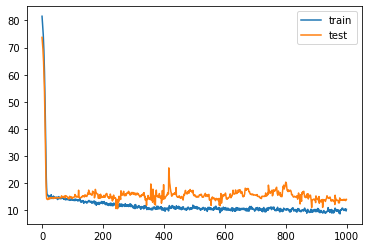

In [17]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Make predictions based on test set and get a root mean squared error 

In [18]:
from sklearn.metrics import mean_squared_error
import math

yhat = bidirectional_lstm_model.predict(test_X)
mse = mean_squared_error(test_y, yhat)
rmse = math.sqrt(mse)

In [19]:
rmse

17.83769970560753